# Attempting some basic aperture photometry (yeet)

Based on method used in previous source detection test

First up, dependencies:

In [134]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.table import Column
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from matplotlib.colors import LogNorm
import astroalign as aa
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize

Importing .fits file, extracting the ~ *data* ~, and converting the image to counts:

In [135]:
#image_file = 'example_data/PAL5_3p6um.fits'
image_file = 'data/PAL5/PAL5__e1/PAL5__e1_4p5um.fits'
#image_data = fits.getdata(image_file, ext=0)
#print(image_data.shape)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
image_data = hdu_list[0].data   # could open data here instead of fits.getdata above, more consistent
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
hdu_list.close()

data = image_data * exptime / fluxconv

#print(hdr)
w = wcs.WCS(hdr)
print(w)
#w.wcs.print_contents()

pixcrd = np.array([[300, 300], [360, 550], [600, 250]], dtype=np.float64)
world = w.wcs_pix2world(pixcrd, 0)
print(world)

EXPTIME: 81.4431
FLUXCONV: 0.1447
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 229.01073  -0.167517  
CRPIX : 704.554985  346.90351  
CD1_1 CD1_2  : -2.76759076885448e-05  -0.000164356116508073  
CD2_1 CD2_2  : -0.000164356116508073  2.76759076885448e-05  
NAXIS : 1408  693
[[ 2.29029443e+02 -1.02460714e-01]
 [ 2.28986694e+02 -1.05403096e-01]
 [ 2.29029358e+02 -1.53151314e-01]]


Locating the objects in the image using DAOStarFinder, and plotting no. of stars detected vs. sigma curve:

In [136]:
#def detect_sources(data, sigma_level, FWHM):
#    daofind = DAOStarFinder(threshold = sigma_level * std, fwhm=FWHM)
#    sources = daofind(data - median)
#    return sources

Plotting the number of stars detected across a range of sigma values, allowing us to estimate the best sigma level to use:

In [137]:
mean, median, std = sigma_clipped_stats(data, sigma=6.) # don't need mean any more?
median_alt = np.nanmedian(data)  # just testing a different median out (i think sigma clipped is probably better)

#print(median, bkg_median)

In [138]:
#no_detected = []
#sigma_vals = []
#fwhm = 5.

#for i in np.arange(1., 15.5, 0.5):
#    #print(i)
#    daofind = DAOStarFinder(threshold = i * std, fwhm = fwhm)
#    sources = daofind(data - median)
#    #print(len(sources))
    
#    no_detected.append(len(sources))
#    sigma_vals.append(i)

#print(no_detected)
#print(sigma_vals)

In [139]:
#plt.plot(sigma_vals, no_detected)
#plt.xlabel('sigma')
#plt.ylabel('number of sources detected')
#plt.grid(True)

#plt.savefig('images/sigma_curve_fwhm5.png', dpi=100)

Adding the centroid positions of the objects to an array and fitting circular apertures and annuli around them:

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


576


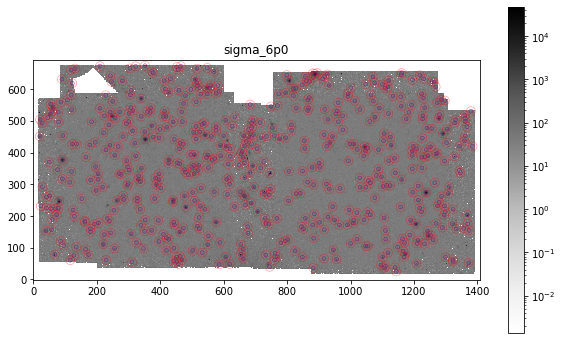

In [140]:
sigma_level = 6.

# 4 sigma seems ideal to me
# fwhm = 3. is roughly the average of many stars tested with imexam (using 1d gaussian fit)
# vicky uses radial fwhm, which varies between 4 - 6 ish; mean is ~4.9, so i'll try 5
# i like the roundness limits at +/- 0.5 personally

#daofind = DAOStarFinder(threshold = sigma_level * std, fwhm = 5.)
daofind = DAOStarFinder(threshold = sigma_level * std, fwhm = 5., roundlo = -0.5, roundhi = 0.5)
sources = daofind(data - median)   # think: do i need to subtract bkg here? or later?

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)
plt.gcf().set_size_inches(10, 6)

plotname = str(int(sigma_level)) + 'p' + str(int(10 * (sigma_level - int(sigma_level))))
plt.title('sigma_' + plotname)
#plt.savefig('images/sigma_' + plotname, dpi=500)
#plt.savefig('images/yikes_e9.png', dpi=800)

print(len(sources))

Performing some basic aperture photometry, summing the pixel brightness values (fluxes?) inside each aperture and annulus:

(Note: 'nan' values for apertures are where the objects are too close to the edge of the image and use some pure white in their summation, and those for the annuli are where annuli overlap)

In [141]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 1144.5399 24.854201            nan            nan
  2  882.2909 36.005182      6823.0266            nan
  3  1106.997 36.662134      6630.7142      23637.445
  4 1140.4175 37.684209      5975.3759      21494.731
  5 744.48467 39.806977            nan            nan
  6 1109.6827 41.697305      6354.6922      22991.244
  7 1095.9628 45.167765      7048.7102      24874.886
  8 585.06859 47.504311            nan            nan
  9 456.42435 49.111055      5400.9981            nan
 10  618.7378 48.885746       11999.92            nan
...       ...       ...            ...            ...
567 456.27121 661.40751      24419.335      22418.524
568  131.0631 665.14486      8522.6546            nan
569 515.64509 664.95694      10372.169            nan
570 304.30084 665.67306      6268.8486            nan
571 547.91955 667.30836     

Estimating the local background in the annuli by finding the mean brightness within:

In [142]:
bkg_mean = phot_table['aperture_sum_1'] / annuli.area
#bkg_sum = bkg_mean * apertures.area
#phot_table['bkg_sum'] = bkg_sum
phot_table['bkg_sum'] = bkg_mean * apertures.area
phot_table['residual_sum_mean'] = phot_table['aperture_sum_0'] - phot_table['bkg_sum']
#phot_table['residual_sum_mean'] = final_sum

#for col in final_data.colnames:
#    final_data[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  ... aperture_sum_1  bkg_sum  residual_sum_mean
       pix       pix    ...                                           
--- --------- --------- ... -------------- --------- -----------------
  1 1144.5399 24.854201 ...            nan       nan               nan
  2  882.2909 36.005182 ...            nan       nan               nan
  3  1106.997 36.662134 ...      23637.445 5318.4252          1312.289
  4 1140.4175 37.684209 ...      21494.731 4836.3144         1139.0615
  5 744.48467 39.806977 ...            nan       nan               nan
  6 1109.6827 41.697305 ...      22991.244   5173.03         1181.6622
  7 1095.9628 45.167765 ...      24874.886 5596.8493         1451.8609
  8 585.06859 47.504311 ...            nan       nan               nan
  9 456.42435 49.111055 ...            nan       nan               nan
 10  618.7378 48.885746 ...            nan       nan               nan
...       ...       ... ...            ...       ...               ...
567 45

Alternate method: better stats yay (sigma-clipped median in the annuli):

In [143]:
annulus_masks = annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]   # create 1d array of pixel values in the mask
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
#phot = aperture_photometry(data, apertures)
phot_table['annulus_median'] = bkg_median
phot_table['aper_bkg'] = bkg_median * apertures.area
phot_table['aper_sum_bkgsub'] = phot_table['aperture_sum_0'] - phot_table['aper_bkg']

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

WARNING

 id  xcenter   ycenter  ... annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix    ...                                         
--- --------- --------- ... -------------- --------- ---------------
  1 1144.5399 24.854201 ...      41.777405 4724.9132             nan
  2  882.2909 36.005182 ...      42.884682 4850.1432       1972.8833
  3  1106.997 36.662134 ...      45.359715 5130.0629       1500.6514
  4 1140.4175 37.684209 ...       41.38961 4681.0546       1294.3212
  5 744.48467 39.806977 ...      66.435608 7513.6902             nan
  6 1109.6827 41.697305 ...      43.866659 4961.2023       1393.4899
  7 1095.9628 45.167765 ...      46.588516 5269.0371       1779.6732
  8 585.06859 47.504311 ...      54.788427 6196.4252             nan
  9 456.42435 49.111055 ...      44.535166 5036.8086       364.18953
 10  618.7378 48.885746 ...      69.813126 7895.6785       4104.2416
...       ...       ... ...            ...       ...             ...
567 456.27121 661.40751 ...      4

: Input data contains invalid values (NaNs or infs), which were automatically clipped. [astropy.stats.sigma_clipping]


Trying to calculate the apparent magnitudes of each star:

I think the negative 'aper_sum_bkgsub's happen in crowded areas where the annulus counts another star as the background, so the bkg value is larger than the aperture sum, or where the star itself is so dim the bkg est is higher, or a mix of both. Does this mean I need a higher threshold or fwhm to rule out the dim boyos? Who knows

In [144]:
#flux_zeromag = 280.9         # from Reach et al 2005, section 5.4; for 3.6 band, = 280.9 +/- 4.1; for 4.5, = 179.7 +/- 2.6
flux_zeromag = 179.7
#zmag = 18.80                  # given in/calculated using IRAC handbook, section 4.8; for 4.5um, = 18.3177 = 18.32
zmag = 18.32
#aperture_correction = 1.125  # for 6, 6-14 pix apertures in channel 1; given in IRAC handbook, table 4.7; channel 2 = 1.120
aperture_correction = 1.120
conv = fluxconv / exptime
negative_sums = []

phot_table['apparent_mag_mean'] = float('NaN')
phot_table['apparent_mag_median'] = float('NaN')   # idk why i have to fill the new column with NaNs first but hey ho it works

for i in range(len(phot_table)):
    if phot_table['residual_sum_mean'][i] >= 0:
        phot_table['apparent_mag_mean'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_table['residual_sum_mean'][i])
    if phot_table['aper_sum_bkgsub'][i] >= 0:
        phot_table['apparent_mag_median'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_table['aper_sum_bkgsub'][i])
    else:
        negative_sums.append(phot_table['id'][i])

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)
#print(negative_sums)

print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_mean'])))
print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_median'])))

print(phot_table['aper_sum_bkgsub'])

 id  xcenter   ycenter  ... apparent_mag_mean apparent_mag_median
       pix       pix    ...                                      
--- --------- --------- ... ----------------- -------------------
  1 1144.5399 24.854201 ...               nan                 nan
  2  882.2909 36.005182 ...               nan           16.835166
  3  1106.997 36.662134 ...         17.277846            17.13222
  4 1140.4175 37.684209 ...         17.431551           17.292814
  5 744.48467 39.806977 ...               nan                 nan
  6 1109.6827 41.697305 ...         17.391686            17.21266
  7 1095.9628 45.167765 ...         17.168107           16.947069
  8 585.06859 47.504311 ...               nan                 nan
  9 456.42435 49.111055 ...               nan           18.669601
 10  618.7378 48.885746 ...               nan           16.039837
...       ...       ... ...               ...                 ...
567 456.27121 661.40751 ...         14.354806           14.341246
568  131.0

## Writing to file:

In [145]:
phot_table['id', 'xcenter', 'ycenter', 'apparent_mag_median'].write('outputs/e1_4p5.txt', format='csv', overwrite=True)

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         2.,  0.,  1.,  0.,  1.,  1.,  3.,  1.,  2.,  3.,  1.,  1.,  1.,
         0.,  0.,  0.,  3.,  1.,  1.,  2.,  0.,  1.,  0.,  1.,  4.,  3.,
         2.,  0.,  3.,  1.,  0.,  1.,  1.,  0.,  2.,  1.,  0.,  1.,  1.,
         2.,  5.,  1.,  1.,  5.,  5.,  3.,  2.,  5.,  3.,  6.,  7.,  2.,
         4.,  3.,  8., 11., 11.,  6.,  5.,  8.,  7.,  6., 13.,  8., 12.,
         8.,  8., 15., 15., 10.,  9., 15., 11., 13., 13., 10., 13., 12.,
         8., 13.,  5., 10.,  9.,  2.,  2.,  4.,  4.,  2.,  3.,  7.,  5.,
         1.,  2.,  1.,  3.,  1.,  3.,  2.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  2.,  0.,  2.,  0.,
         2.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

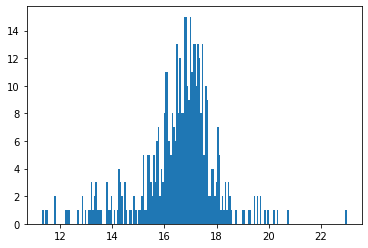

In [146]:
plt.hist(phot_table['apparent_mag_mean'], bins=200)
#plt.hist(phot_table['apparent_mag_median'], bins=200)

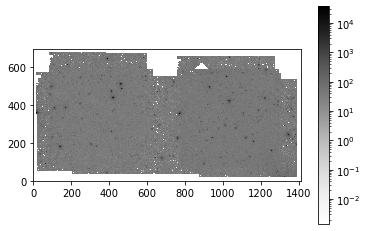

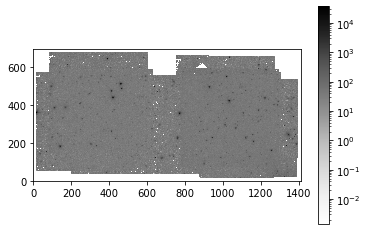

597 594


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


 id  xcenter   ycenter  apparent_mag_comp
       pix       pix                     
--- --------- --------- -----------------
  1  1335.874 23.001977               nan
  2 1325.5626  23.66314               nan
  3 1267.7441 27.173042         17.095888
  4 1138.5661 28.606267         16.832683
  5 1300.4332 29.231301         16.450098
  6   797.788 38.844313               nan
  7 910.65034 40.078595         17.496119
  8 1150.1934  41.17284         15.136468
  9  596.9203 43.066308               nan
 10 386.88452 44.633777         14.083878
...       ...       ...               ...
585 410.78727 650.60498         20.421326
586 889.85879 650.91624         16.082926
587 980.18831 655.87076               nan
588 370.03351 659.64085         17.124302
589 419.44732 664.05577         16.634198
590  282.2265 665.66802          17.64249
591 410.47653  667.3616         16.021173
592 538.13867  667.2605               nan
593 137.23726 667.87497               nan
594 433.06979 672.36633           

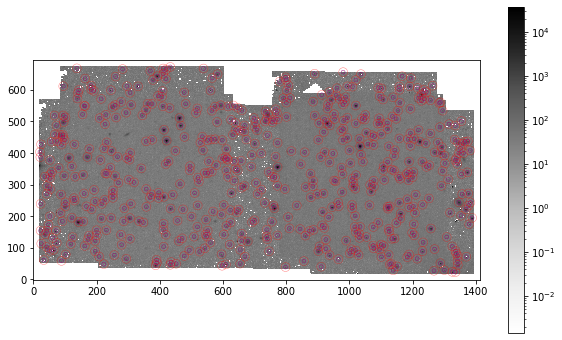

In [106]:
file_comp = 'data/PAL5/PAL5__e2/PAL5__e2_3p6um.fits'

with fits.open(file_comp) as hdu_list:
    image_data_comp = hdu_list[0].data
    hdr_comp = hdu_list[0].header
    data_comp = image_data_comp * hdr_comp['EXPTIME'] / hdr_comp['FLUXCONV']
#print(data[400, 400], np.array(data)[400, 400])
#print(data_to_pd)
#print(np.array(image_data))
#print(data[400, 400], data_comp[400, 400])

data_aligned, footprint = aa.register(np.array(data), np.array(data_comp))

plt.imshow(data_aligned, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
plt.show()
plt.close()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
plt.show()
plt.close()

_, median_comp, std_comp = sigma_clipped_stats(data_aligned, sigma=6.)

daofind_comp = DAOStarFinder(threshold = sigma_level * std_comp, fwhm = 5., roundlo = -0.5, roundhi = 0.5)
sources_comp = daofind_comp(data_aligned - median_comp)

pos_comp = np.transpose((sources_comp['xcentroid'], sources_comp['ycentroid']))
apertures = CircularAperture(pos_comp, r=6.)
annuli = CircularAnnulus(pos_comp, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(data_aligned, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)
plt.gcf().set_size_inches(10, 6)

print(len(sources), len(sources_comp))

phot_comp = aperture_photometry(data_aligned, all_apers)

annulus_masks = annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data_aligned)
    annulus_data_1d = annulus_data[mask.data > 0]   # create 1d array of pixel values in the mask
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
#phot = aperture_photometry(data, apertures)
phot_comp['annulus_median'] = bkg_median
phot_comp['aper_bkg'] = bkg_median * apertures.area
phot_comp['aper_sum_bkgsub'] = phot_comp['aperture_sum_0'] - phot_comp['aper_bkg']

phot_comp['apparent_mag_comp'] = float('NaN')

for i in range(len(phot_comp)):
    if phot_comp['aper_sum_bkgsub'][i] >= 0:
        phot_comp['apparent_mag_comp'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_comp['aper_sum_bkgsub'][i])
        
for col in phot_comp.colnames:
    phot_comp[col].info.format = '%.8g'
print(phot_comp['id', 'xcenter', 'ycenter', 'apparent_mag_comp'])
print(phot_table['id', 'xcenter', 'ycenter', 'apparent_mag_median'])

In [ ]:
#filename_ap = 'outputs/apphot_test01.txt'
#filename_psf = 'outputs/psf_test01.txt'
#file_ap = np.genfromtxt(filename_ap, skip_header=1, delimiter=',', dtype=None, unpack=True, encoding=None)
#file_psf = np.genfromtxt(filename_psf, skip_header=1, delimiter=',', dtype=None, unpack=True, encoding=None)

In [ ]:
#print(file_ap)
#print(np.shape(file_ap))

#mag_ap = []
#mag_ap = file_ap[:,3]
#print(mag_ap)

#testy = np.insert(file_ap, )

In [ ]:
#t = Table.write(phot_table, 'outputs/table_test_ap.', delimiter=',', format='ascii')